In [ ]:

%pip install -r requirements.txt

In [1]:
import uuid
import psycopg2
import pandas as pd
from sqlalchemy import create_engine
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import folium

In [2]:

db_host = "db-application-process-dataeng.postgres.database.azure.com"
db_port = "5432"
db_name = "candidate_8qls"
db_user = "salma_lahrech"
db_password = "@GxxPNkLd3rrqi3S"

# Establish a connection to the PostgreSQL database
conn = psycopg2.connect(
    host=db_host,
    port=db_port,
    dbname=db_name,
    user=db_user,
    password=db_password
)

cur = conn.cursor()





Answer to question 1 in readme file:

In [3]:
#skip 
#load data into dataframe

df_treecsv = pd.read_csv('data/tree_data.csv')
# Create an SQLAlchemy engine
connection_string = 'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'
engine = create_engine(connection_string)
# Append data from DataFrame to the PostgreSQL table
df_treecsv.to_sql('raw_data', engine, index=False, if_exists='append', method='multi', chunksize=1000)
engine.dispose()

**<span style="color:red;">Please remember to respond to the questions in the readme.md file as well and good luck :)</span>**

# DATA QUALITY

### Question 1
In the dataset provided to you, the focus is on trees, farmers, and parcels. At PUR, our primary activity involves planting trees on parcels owned by farmers. This gives you an opportunity to examine data similar to what you would encounter if you eventually join us.

How can you evaluate the quality of the data you have received ? Provide a quick analysis using the tool(s) / libraries of your choice.

In [4]:
#putting the whole table in data frame in order to analize it
cur.execute("SELECT * FROM raw_data")
results = cur.fetchall()
df_rawdata = pd.DataFrame(results, columns=[desc[0] for desc in cur.description])

In [5]:
df_rawdata.head()

,longitude,latitude,size_height,size_width,tree_species,farmer_first_name,farmer_last_name,farmer_national_id,parcel_id,parcel_area,created_at,farmer_birthday,species_latin_name
0,-70.749857,-11.464434,15.49,91.63,Maple,Alejandro,Lopez,4518066197634485419,13f5fcaa-6a0f-5fea-b1b1-7de916e89f62,191.51,2021-08-27 11:32:40,None,Acer
1,-70.529544,-11.494757,21.87,107.71,Maple,Rosa,Rodriguez,4590364070282946098,64f69e1e-8c2a-57f9-bce5-ac10ef1f61b0,43.96,2021-08-23 20:21:20,None,Acer
2,-70.610692,-11.338272,7.06,24.29,Fir,Sebastian,Gonzalez,4869115316512327290,421ddcac-3622-5a93-9500-e30551abab45,164.11,2021-09-07 05:31:55,None,Abies
3,-70.591786,-11.334598,13.44,49.69,Eucalyptus,Sebastian,Gonzalez,4869115316512327290,421ddcac-3622-5a93-9500-e30551abab45,164.11,2021-08-15 10:11:03,None,Eucalyptus
4,-70.550708,-11.472554,20.12,None,Willow,Fernando,Gonzalez,73514415500322874,1005a79a-4349-57a0-af7f-9908d7645291,90.15,2021-09-04 01:59:58,None,Salix


In [6]:
df_rawdata.describe(include='all')

,longitude,latitude,size_height,size_width,tree_species,farmer_first_name,farmer_last_name,farmer_national_id,parcel_id,parcel_area,created_at,farmer_birthday,species_latin_name
count,1358,1358,1358,785,1358,1358,1358,1358,1358,1358,1358,331,1358
unique,320,320,1098,755,9,10,6,11,11,20,1358,10,9
top,-70.749857,-11.464434,14.55,115.55,Bamboo,Carlos,Rodriguez,2525770196998878965,194c0d73-0092-5c49-9a1a-28b9a2c3ac41,102.38,2021-08-27 11:32:40,1970-08-08,Bambusoideae
freq,5,5,5,3,187,192,471,192,192,183,1,62,187


In [9]:
df_rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1358 entries, 0 to 1357
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   longitude           1358 non-null   float64       
 1   latitude            1358 non-null   float64       
 2   size_height         1358 non-null   float64       
 3   size_width          785 non-null    float64       
 4   tree_species        1358 non-null   object        
 5   farmer_first_name   1358 non-null   object        
 6   farmer_last_name    1358 non-null   object        
 7   farmer_national_id  1358 non-null   object        
 8   parcel_id           1358 non-null   object        
 9   parcel_area         1358 non-null   object        
 10  created_at          1358 non-null   datetime64[ns]
 11  farmer_birthday     331 non-null    object        
 12  species_latin_name  1358 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(8)
memo

In [8]:
#type conversion 
df_rawdata['created_at'] = pd.to_datetime(df_rawdata['created_at'])
df_rawdata[['size_width', 'size_height','longitude' ,'latitude']] = df_rawdata[['size_width', 'size_height', 'longitude' ,'latitude']].astype(float)

Answer for question 3 : Creating the data model 

In [10]:
#splitting the dataframe to 4 dataframes
farmers_df = df_rawdata[['farmer_national_id', 'farmer_first_name', 'farmer_last_name', 'farmer_birthday']].drop_duplicates()
parcels_df = df_rawdata[['parcel_id', 'farmer_national_id', 'parcel_area']].drop_duplicates()
trees_df = df_rawdata[['parcel_id', 'tree_species','species_latin_name','longitude','latitude']].drop_duplicates()
#Creating an id for tree df
trees_df['Tree_id'] = [uuid.uuid4() for _ in range(len(trees_df))]



In [11]:
#Creating the observation dataframe by merging it with tree df to have the tree_id 
df_observations = df_rawdata[[ 'parcel_id', 'tree_species', 'size_width', 'size_height', 'created_at']]

df_observations = pd.merge(df_observations, trees_df[['Tree_id', 'parcel_id', 'tree_species']],
                           on=['parcel_id', 'tree_species'], how='left')
df_observations= df_observations.drop(columns=['parcel_id', 'tree_species'])
#df_observations.describe(include='all')

Answer for question 4

In [12]:
#By using Python, provide a modelization of a farmer and by running your code,
# you would get a farmer's instance (the data can be mocked or from the database)
class Farmer:
    def __init__(self, first_name, last_name, national_id, birthday, address):
        self.first_name = first_name
        self.last_name = last_name
        self.national_id = national_id
        self.birthday = birthday
        self.address = address

    def __repr__(self):
        return (f"Farmer({self.first_name} {self.last_name}, "
                f"ID: {self.national_id}, Birthday: {self.birthday}, Address: {self.address})")

# Create an instance of Farmer with mock data
mock_farmer = Farmer("John", "Doe", "123456789", "1980-07-01", "123 Elm Street")

# Print the farmer's instance to see the output
print(mock_farmer)


Farmer(John Doe, ID: 123456789, Birthday: 1980-07-01, Address: 123 Elm Street)


### Question 2

One of the column is provided with sparse information.

What could be a strategy to handle this situation ? Implement it here (you do not have to persist this solution in the database).

In [13]:
#delete the whole column because it is not useful for our analysis
farmers_df= farmers_df.drop(columns=['farmer_birthday'])

# DATA ANALYSIS

#### Question 3
The marketing department seeks information on the total count of farmers and parcels participating in this project.

What output could you provide them to give the best insight about this problematic ?

In [15]:
# Counting the number of unique farmers
num_farmers = farmers_df['farmer_national_id'].nunique()

# Counting the number of parcels
num_parcels = parcels_df['parcel_id'].nunique()

print(f"Total number of farmers: {num_farmers}")
print(f"Total number of parcels: {num_parcels}")


Total number of farmers: 11
Total number of parcels: 11


#### Question 4
One of our agroforestry expert is wondering if there's a correlation between the weidth and the height of a tree.

Can you provide an answer to her?

In [16]:
# Check for any missing values in the relevant columns
df_corelation=df_observations.dropna(subset=['size_width', 'size_height'])


# Calculate the Pearson correlation coefficient
correlation, _ = pearsonr(df_corelation['size_width'], df_corelation['size_height'])
print(f'The Pearson correlation coefficient between tree width and height is: {correlation}')


The Pearson correlation coefficient between tree width and height is: 0.9360996624060712


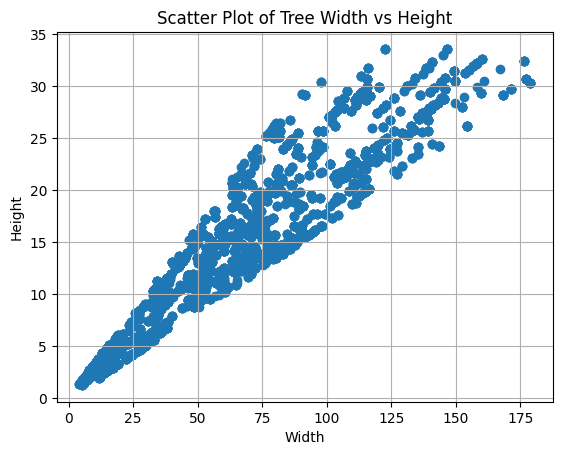

In [17]:


plt.scatter(df_corelation['size_width'], df_corelation['size_height'])
plt.title('Scatter Plot of Tree Width vs Height')
plt.xlabel('Width')
plt.ylabel('Height')
plt.grid(True)
plt.show()


#### Question 5
At PUR, our mission is to accelerate biodiversity regeneration through strategic tree planting. A key factor in this effort is identifying which tree species exhibit the most significant growth over time, as this can influence our planting decisions.

Therefore, we're interested in understanding the growth patterns of these species. Could you analyze this data to identify which species demonstrates the highest growth rate? For the purpose of this analysis, consider that a species is considered to be growing if its height and/or width increases over time.

Please provide an analysis that ranks the tree species by their growth rate, helping us to pinpoint the species that could contribute most effectively to our biodiversity regeneration efforts

In [18]:
#creating a new df which a subset of df observations
df_growth=df_observations.dropna(subset=['Tree_id', 'size_width', 'size_height', 'created_at']).copy()

In [54]:
# Dropping rows where any of these crucial columns are missing
df_growth.sort_values(by=['created_at'], inplace=True)

# Calculate differences in height and width
df_growth['HeightGrowth'] = df_growth.groupby('Tree_id')['size_height'].diff().fillna(0)
df_growth['WidthGrowth'] = df_growth.groupby('Tree_id')['size_width'].diff().fillna(0)

# Sum the growth rates to a single growth metric if needed
df_growth['TotalGrowth'] = df_growth['HeightGrowth'] + df_growth['WidthGrowth']



In [55]:
#merge to get the species name
df_growth = pd.merge(df_growth, trees_df[['Tree_id', 'tree_species']],on=['Tree_id'])

# Calculate average total growth for each species
growth_by_species = df_growth.groupby('tree_species')['TotalGrowth'].mean().reset_index()

# Sort the results to see which species has the highest average growth
sorted_growth = growth_by_species.sort_values(by='TotalGrowth', ascending=False)


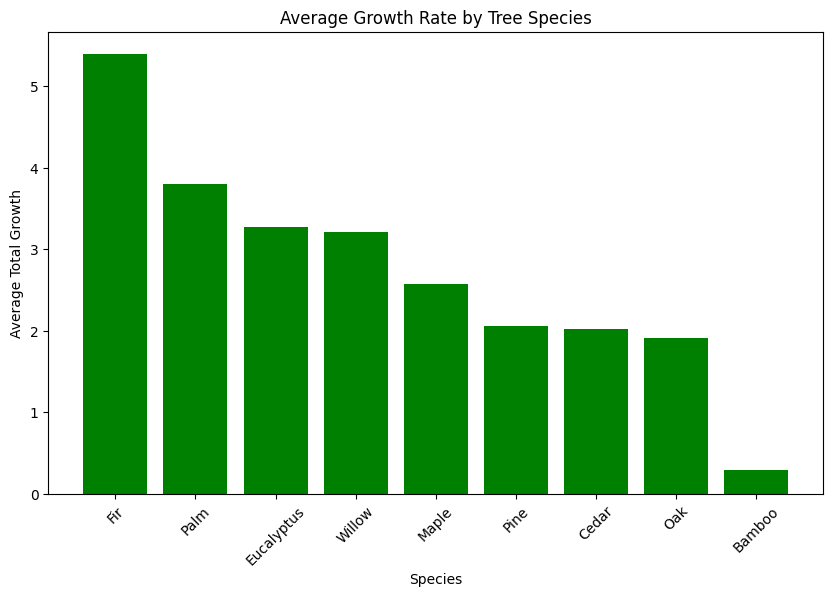

In [56]:
#Plotting 
plt.figure(figsize=(10, 6))
plt.bar(sorted_growth['tree_species'], sorted_growth['TotalGrowth'], color='green')
plt.xlabel('Species')
plt.ylabel('Average Total Growth')
plt.title('Average Growth Rate by Tree Species')
plt.xticks(rotation=45)
plt.show()


### Question 6 (Bonus) - ONLY IF YOU APPLIED TO THE DATA/BI ENGINEERING POSITION

The client who is financing this agroforestry project is asking you to display a map where he could:
- Vizualize **the location** of the planted trees
- Distinguish the trees by **height**


Can you create such visualization using the tool(s) / libraries of your choice.

In [9]:
# Sort the data by tree and date to ensure the latest date comes last
df_observations.sort_values(by=['Tree_id', 'created_at'], ascending=[True, False], inplace=True)

# Drop duplicates, keeping the last entry which is the latest one
latest_measurements = df_observations.drop_duplicates(subset='Tree_id', keep='first')



,size_width,size_height,created_at,Tree_id
4466,NaN,28.77,2023-09-29 17:31:37,00ed73e7-248f-4a07-90f2-605a53e064b9
4462,NaN,28.77,2023-09-29 17:31:37,013e13f0-abff-4522-be7c-c31612c9b2fe
4953,38.93,11.09,2023-10-02 22:55:32,0208c820-012b-48f6-8c93-b4121307af14
4895,79.83,19.71,2023-10-03 04:00:27,02a488e7-0f75-4c57-89d4-f9f6d0dda124
4406,NaN,33.50,2023-10-03 18:25:33,032bd0ca-06c8-44f6-bcf9-2d011b009fe4


In [13]:
# merge with tree df to get the species name 
trees_latest_measure = pd.merge(trees_df[['Tree_id','tree_species', 'longitude', 'latitude']], latest_measurements[['Tree_id', 'size_height']], on='Tree_id', how='left')
trees_latest_measure.head()

,Tree_id,tree_species,longitude,latitude,size_height
0,ce0daa67-0d3d-4720-99df-2e2d9ed34951,Maple,-70.749857,-11.464434,28.55
1,511903d7-7d2a-4f8a-9f00-3dde4d764c9e,Maple,-70.529544,-11.494757,30.69
2,693ee7c3-8461-4aad-8ddb-68d373ca73aa,Fir,-70.610692,-11.338272,11.41
3,06763141-edb3-466f-8eb9-d3cbac323f07,Eucalyptus,-70.591786,-11.334598,6.80
4,013e13f0-abff-4522-be7c-c31612c9b2fe,Willow,-70.550708,-11.472554,28.77


In [15]:

# Create the map centered around the average location of the trees
map = folium.Map(location=[trees_latest_measure['latitude'].mean(), trees_latest_measure['longitude'].mean()], zoom_start=13)

# Add markers to the map using the latest height data
for _, tree in trees_latest_measure.iterrows():
    if pd.notna(tree['size_height']):  # Check if size_height is not NaN
        folium.CircleMarker(
            location=[tree['latitude'], tree['longitude']],
            radius=tree['size_height'] * 0.1,  # Adjust size scaling to suit the data
            popup=f"Tree ID: {tree['Tree_id']}\nHeight: {tree['size_height']} meters",
            color='green',
            fill=True,
            fill_color='green'
        ).add_to(map)

# Save the map as an HTML file
map.save('map_of_trees.html')


In [16]:
#showing the map
map

### Question 6 (Bonus) - ONLY IF YOU APPLIED TO THE CONFIRMED DATA-ENGINEERING POSITION

Using Python and any framework of your choice, can you create an endpoint that allows us to query the number of parcels associated with a specific farmer.

We expect a response that looks like below but feel free to add any relevant information in this payload. For your information, the response_id is a randomly generated UUID.

In [ ]:
{
    "parcels": [
        {id: "4f2cd9d6-5db6-5081-92a5-517f1b92949a"},
        {id: "1005a79a-4349-57a0-af7f-9908d7645291"}
    ],
    "reponse_id": "0cc12fda-deca-4f24-918b-f0884d2bb910"
    "total": 2
}

In [19]:
cur.close()
conn.close()